In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# VAE 구현

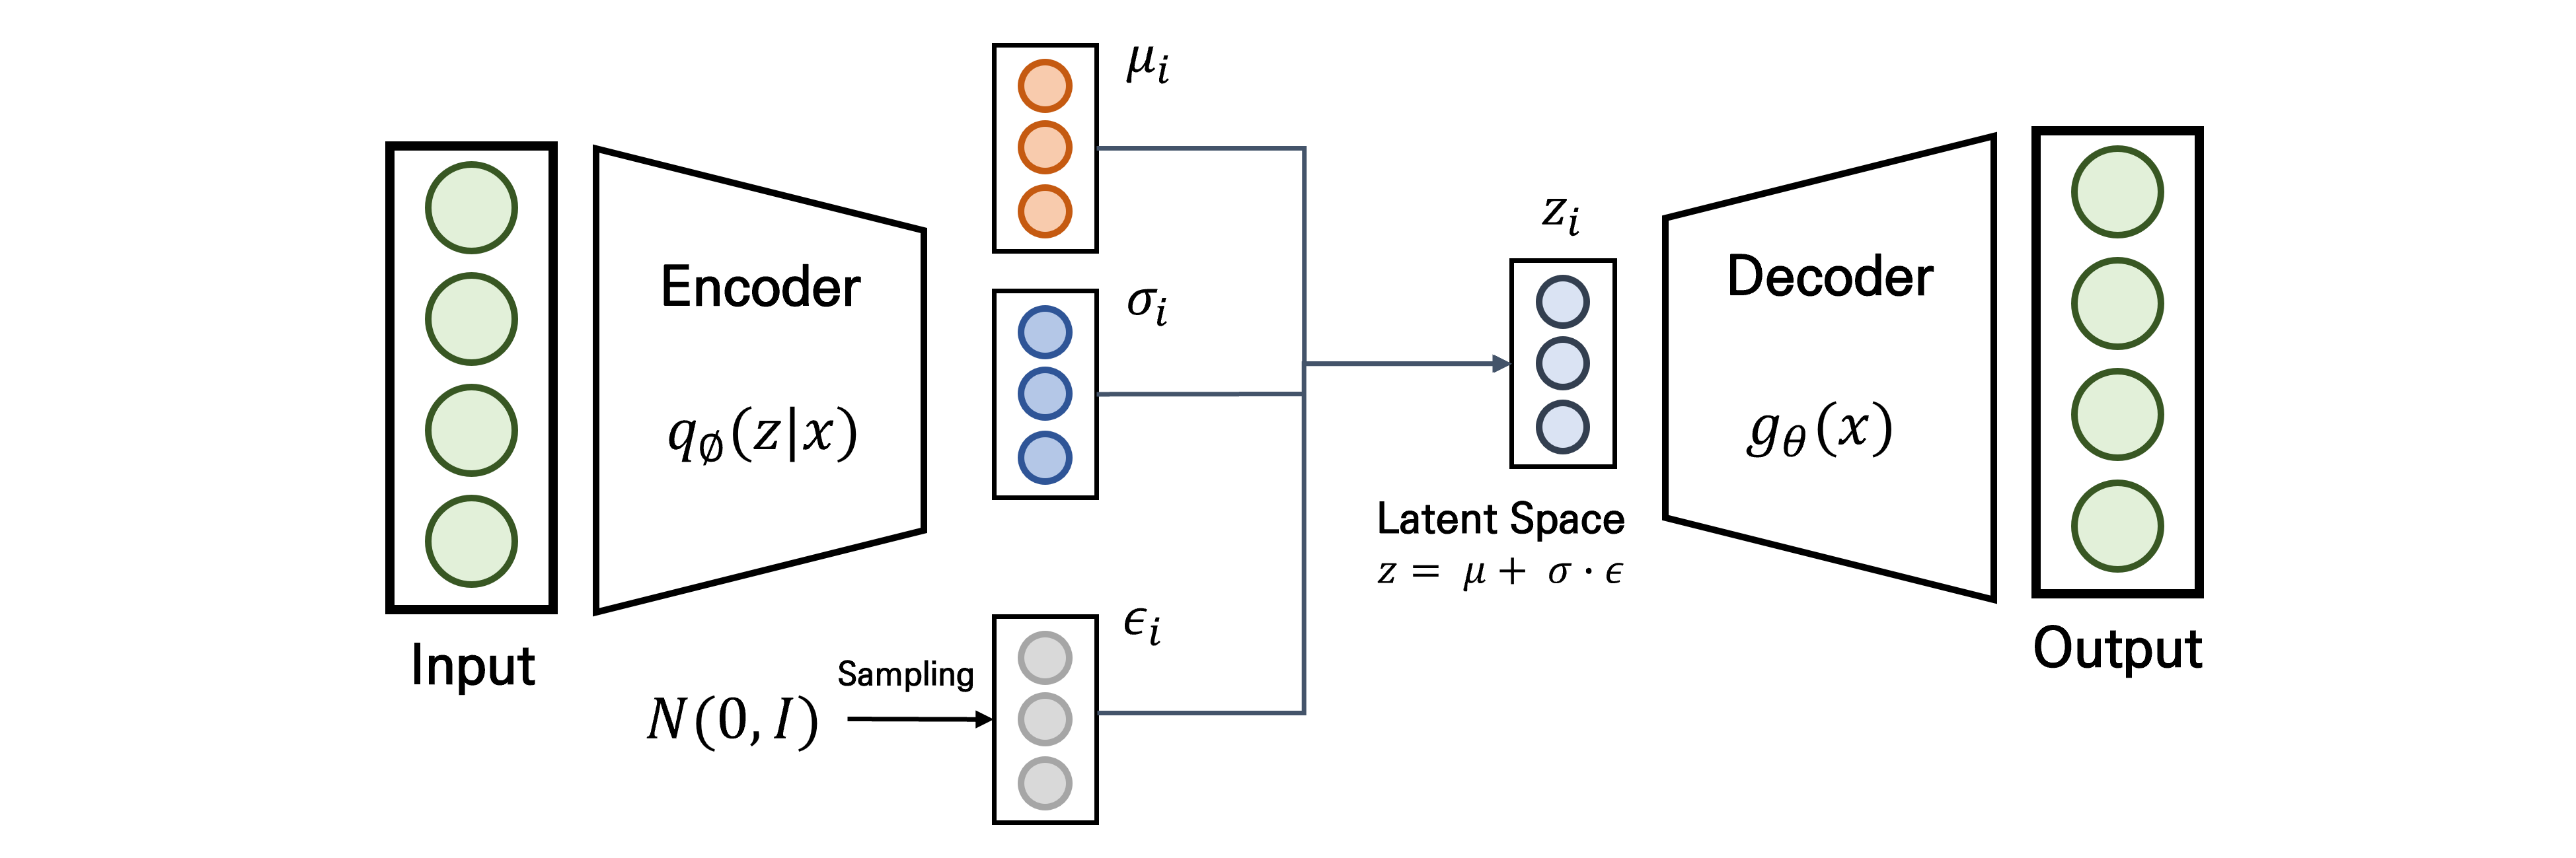

In [27]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
import torchvision.datasets as dsets
import itertools
from torch.autograd import Variable
import torch.optim as optim
from tqdm.auto import tqdm
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import datetime
import os

In [28]:
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("사용하는 Device : ", DEVICE)

# colab의 시간은 한국 시간보다 9시간이 느림
current_time = datetime.datetime.now() + datetime.timedelta(hours= 9)
current_time = current_time.strftime('%Y-%m-%d-%H:%M')

saved_loc = os.path.join('/content/drive/MyDrive/VAE_Result', current_time)
os.mkdir(saved_loc)

print("저장 위치: ", saved_loc)

사용하는 Device :  cuda
저장 위치:  /content/drive/MyDrive/VAE_Result/2023-02-25-23:59


In [29]:
# Tensorboard를 써주기
writer = SummaryWriter(saved_loc)
EPOCHS = 50
BATCH_SIZE = 200

## DataSet

In [30]:
# Transformer code
transformer = transforms.Compose([
            transforms.ToTensor() # numpy array를 tensor로 변환
])


# Loading trainset, testset and trainloader, testloader
trainset = torchvision.datasets.MNIST(root = '/content/drive/MyDrive/MNIST', train = True,
                                        download = True, transform = transformer)

trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)


testset = torchvision.datasets.MNIST(root = '/content/drive/MyDrive/MNIST', train = False,
                                        download = True, transform = transformer)

testloader = torch.utils.data.DataLoader(testset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

<class 'torch.Tensor'>
torch.Size([3, 32, 242])


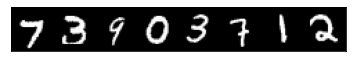

In [31]:
 # sample check
sample, label = next(iter(trainloader))

# show grid image
def imshow_grid(img):
    img = torchvision.utils.make_grid(img)
    print(type(img))
    print(img.shape)
    plt.imshow(img.permute(1, 2, 0))
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.show()


imshow_grid(sample[0:8])

## Encoder

In [32]:
class Encoder(nn.Module):
    def __init__(self, image_size, hidden_size_1, hidden_size_2,latent_size):
        super(Encoder, self).__init__()

        self.fc_1 = nn.Sequential(
            nn.Linear(image_size, hidden_size_1),
            nn.BatchNorm1d(hidden_size_1),
            nn.LeakyReLU(0.1),

            nn.Linear(hidden_size_1, hidden_size_2),
            nn.BatchNorm1d(hidden_size_2),
            nn.LeakyReLU(0.1),

            # nn.Linear(hidden_size_2, latent_size),
            # nn.BatchNorm1d(latent_size),
            # nn.LeakyReLU(0.1),            
        )
        self.fc_2 = nn.Sequential(
            nn.Linear(hidden_size_2, latent_size),
            nn.LeakyReLU(0.1),  
        )
        self.fc_3 = nn.Sequential(
            nn.Linear(hidden_size_2, latent_size),
            nn.LeakyReLU(0.1),  
        )

    def sampling(self, z_mu, z_log_var):
        z_sigma = torch.exp(0.5*z_log_var)
        epsilon = torch.rand_like(z_sigma)
        
        return z_mu + z_sigma*epsilon

    def forward(self, x):
        x = x.view(BATCH_SIZE, -1)
        x = self.fc_1(x)
        z_mu = self.fc_2(x)
        # 원래는 z_sigma를 구해야 하지만, 표준편차의 값이 음수가 되지 않기 위해
        # log(sigma^2) = log(var)로 구한 것입니다.
        z_log_var = self.fc_3(x) 
        z = self.sampling(z_mu, z_log_var)
    
        return z_mu, z_log_var, z

## Decoder

In [33]:
class Decoder(nn.Module):
    def __init__(self, image_size, hidden_size_1, hidden_size_2,latent_size):
        super(Decoder, self).__init__()

        self.fc = nn.Sequential(
            nn.Linear(latent_size, hidden_size_2),
            nn.BatchNorm1d(hidden_size_2),
            nn.LeakyReLU(0.1),

            nn.Linear(hidden_size_2, hidden_size_1),
            nn.BatchNorm1d(hidden_size_1),
            nn.LeakyReLU(0.1),

            # nn.Linear(hidden_size_1, image_size),
            # nn.BatchNorm1d(image_size),
            # nn.LeakyReLU(0.1),

            nn.Linear(hidden_size_1, image_size),
            nn.Sigmoid()            
        )
    
    def forward(self, z):
        x = self.fc(z)
        
        return x


## VAE

In [34]:
class VAE(nn.Module):
    def __init__(self, image_size, hidden_size_1, hidden_size_2,latent_size):
        super(VAE, self).__init__()

        self.encoder = Encoder(image_size, hidden_size_1, hidden_size_2,latent_size)
        self.decoder = Decoder(image_size, hidden_size_1, hidden_size_2,latent_size)

    def forward(self,x, **kwargs):
        z_mu, z_log_var, z = self.encoder(x)
        x_new = self.decoder(z)
        
        return z_mu, z_log_var, x_new


In [35]:
def loss_function(x_new, x, z_mu, z_log_var,image_size):
    bce_loss_func = nn.BCELoss()
    bce_loss = bce_loss_func(x_new, x.view(-1,image_size))
    kld_loss = -0.5*torch.sum(1 + z_log_var - z_mu.pow(2) - z_log_var.exp())

    return bce_loss + kld_loss

# Train

In [36]:
VAE = VAE(28*28,1024,512,256).to(DEVICE)
optimizer = optim.Adam(VAE.parameters(), lr=1e-3)

In [37]:
def train(epoch, model, train_loader, optimizer):
    model.train()
    train_loss = 0
    for batch, (data, _) in enumerate(train_loader):
        x = data.to(DEVICE)
        optimizer.zero_grad()

        z_mu, z_log_var, x_new = model(x)
        loss = loss_function(x_new, x, z_mu, z_log_var,28*28)
        loss.backward()

        train_loss += loss.item()

        optimizer.step()

        if batch % 100 == 0:
            print("Train Epoch : {} [{}/{} ({:.0f}%)]\t Loss : {:.6f}".format(
                epoch, batch*len(x), len(train_loader.dataset),
                100 * batch / len(train_loader),loss.item()/len(x)))
   
    print("======> Epoch: {} Average loss: {:.4f}".format(
        epoch, train_loss / len(train_loader.dataset)
    ))            


In [38]:
def test(epoch, model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch, (data, _) in enumerate(test_loader):
            x = data.to(DEVICE)

            z_mu, z_log_var, x_new = model(x)
            loss = loss_function(x_new, x, z_mu, z_log_var, 28*28)
            if batch == 0:
                n = min(x.size(0), 8)
                comparison = torch.cat([x[:n], x_new.view(BATCH_SIZE, 1, 28, 28)[:n]]) # (16, 1, 28, 28)
                grid = torchvision.utils.make_grid(comparison.cpu()) # (3, 62, 242)

In [39]:
def latent_to_image(epoch, model):
    with torch.no_grad():
        sample = torch.randn(64, 256).to(DEVICE)
        x_new = model.decoder(sample).cpu()
        grid = torchvision.utils.make_grid(x_new.view(64, 1, 28, 28))
        writer.add_image("Latent To Image", grid, epoch)

In [40]:
for epoch in tqdm(range(0, EPOCHS)):
    train(epoch, VAE, trainloader, optimizer)
    test(epoch, VAE, testloader)
    print("\n")
    # latent_to_image(epoch, VAE)

  0%|          | 0/50 [00:00<?, ?it/s]

Train Epoch : 0 [0/60000 (0%)]	 Loss : 17.965863
Train Epoch : 0 [20000/60000 (33%)]	 Loss : 0.045307
Train Epoch : 0 [40000/60000 (67%)]	 Loss : 0.013638
======> Epoch: 0 Average loss: 0.2477


Train Epoch : 1 [0/60000 (0%)]	 Loss : 0.009499
Train Epoch : 1 [20000/60000 (33%)]	 Loss : 0.006158
Train Epoch : 1 [40000/60000 (67%)]	 Loss : 0.008263
======> Epoch: 1 Average loss: 0.0077


Train Epoch : 2 [0/60000 (0%)]	 Loss : 0.010147
Train Epoch : 2 [20000/60000 (33%)]	 Loss : 0.010363
Train Epoch : 2 [40000/60000 (67%)]	 Loss : 0.011325
======> Epoch: 2 Average loss: 0.0086


Train Epoch : 3 [0/60000 (0%)]	 Loss : 0.007087
Train Epoch : 3 [20000/60000 (33%)]	 Loss : 0.009386
Train Epoch : 3 [40000/60000 (67%)]	 Loss : 0.007086
======> Epoch: 3 Average loss: 0.0084


Train Epoch : 4 [0/60000 (0%)]	 Loss : 0.005594
Train Epoch : 4 [20000/60000 (33%)]	 Loss : 0.004852
Train Epoch : 4 [40000/60000 (67%)]	 Loss : 0.009789
======> Epoch: 4 Average loss: 0.0066


Train Epoch : 5 [0/60000 (0%)

KeyboardInterrupt: ignored

In [46]:
torch.save(VAE.state_dict(),"VAE.pth")

In [43]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

## 시각화

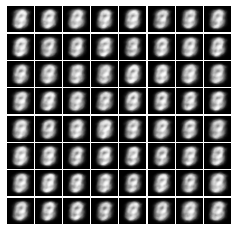

In [44]:
Z_v = Variable(torch.FloatTensor(8*8*256).normal_(0,1).view(64,-1)).to(DEVICE)

samples = VAE.decoder(Z_v).cpu().data.numpy()
fig = plt.figure(figsize=(4, 4))
gs = gridspec.GridSpec(8, 8)
gs.update(wspace=0.05, hspace=0.05)
for j, sample in enumerate(samples):
    ax = plt.subplot(gs[j])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(sample.reshape(28, 28), cmap='Greys_r')
fig.savefig("test_imgs_{}.png".format(epoch))